# Fit regression models of seal abundance and presence
This notebook uses the information on the estimated number of seals per 5 x 5 KM grid cell to build regression models that aim to explain some of the factors that explain the observed distribution and abundance of Weddell seals around Antarctica.

Run this file every time you run the notebook "Attribute geospatial data with seal abundance data", as it means you have new geospatial covariates to analyze.

### Loading the required libraries and other dependencies

In [77]:
## Clear memory
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1299498,69.5,2637877,140.9,2637877,140.9
Vcells,1657833,12.7,22658849,172.9,41186610,314.3


In [94]:
libs<-c("ggplot2","plyr","dplyr","sp","rgeos","raster","rgdal")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"/home/ubuntu/Workspace/ContinentalWESEestimates/"

## Load the source utility functions file
source(file=paste0(pathToLocalGit,"scripts/fitRegressionModels_functions.R"))

## load the WESE grid data
load(file=paste0(pathToLocalGit,"data/continentalWESE.RData"))
head(wesedf)

dataproj<-"+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,adpecol,empedist,empecol,cont300dist,cont800dist,coords.x1,coords.x2,mdlCol,mdlIsl,hasMaps
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,68791,2.621992,-2846.908,2.5563672,-2864.911,206728.3,247849.6,2351,-2273383,2327082,⋯,Ferrier Peninsula,1013124,Snow Hill Island,142791.6,588996.1,-2191000,2511000,0,0,0
2,68792,4.591249,-2587.330,4.4836812,-2612.724,208790.2,250334.0,2351,-2273383,2327082,⋯,Ferrier Peninsula,1014024,Snow Hill Island,142791.6,588996.1,-2186000,2511000,0,0,0
3,68819,1.411659,-3014.080,1.5170590,-3024.577,200154.1,241050.2,2351,-2273383,2327082,⋯,Ferrier Peninsula,1007323,Snow Hill Island,138016.9,584654.8,-2196000,2506000,0,0,0
4,68820,1.413779,-2920.630,0.7565953,-2930.036,202161.9,243501.3,2351,-2273383,2327082,⋯,Ferrier Peninsula,1008204,Snow Hill Island,138016.9,584654.8,-2191000,2506000,0,0,0
5,68821,4.561732,-2686.220,4.5623317,-2716.875,204263.8,246029.6,2351,-2273383,2327082,⋯,Ferrier Peninsula,1009109,Snow Hill Island,138016.9,584654.8,-2186000,2506000,0,0,0
6,68822,4.902608,-2264.930,5.1146288,-2277.257,206460.4,248632.8,2351,-2273383,2327082,⋯,Ferrier Peninsula,1010037,Snow Hill Island,138016.9,584654.8,-2181000,2506000,0,0,0


## Regresion analysis preliminaries

The above tble (wesedf) is ready for fitting regression models, but first we will need the following:
1. Be able to extend the attribution of the table with geospatial hypotheses (e.g., David's WESE zones vs. Michelle's WESE zones)
2. Generate N samples of "no-seal" locations of identical size as the number of grid cells with WESE presence
3. Be able to compute a linear model with the set of N bootstrap samples, and have it summarized for us
  
### On the above needs
__Regarding #1__ it is done with the functions "readShapeFile" and "attributeWithShape". The first function reads the shape file into a spatial object and the second one uses information on the spatial object (e.g., David's WESE zones) into the data.  
Here's an example to load a point shapefile, from an example copied into the repository's data folder:

OGR data source with driver: ESRI Shapefile 
Source: "/home/ubuntu/Workspace/ContinentalWESEestimates/data/glaciers", layer: "glaciers"
with 1499 features
It has 69 fields
Integer64 fields read as strings:  objectid gaz_id scar_commo coordinate altitude_a max_digita location_m country_id 


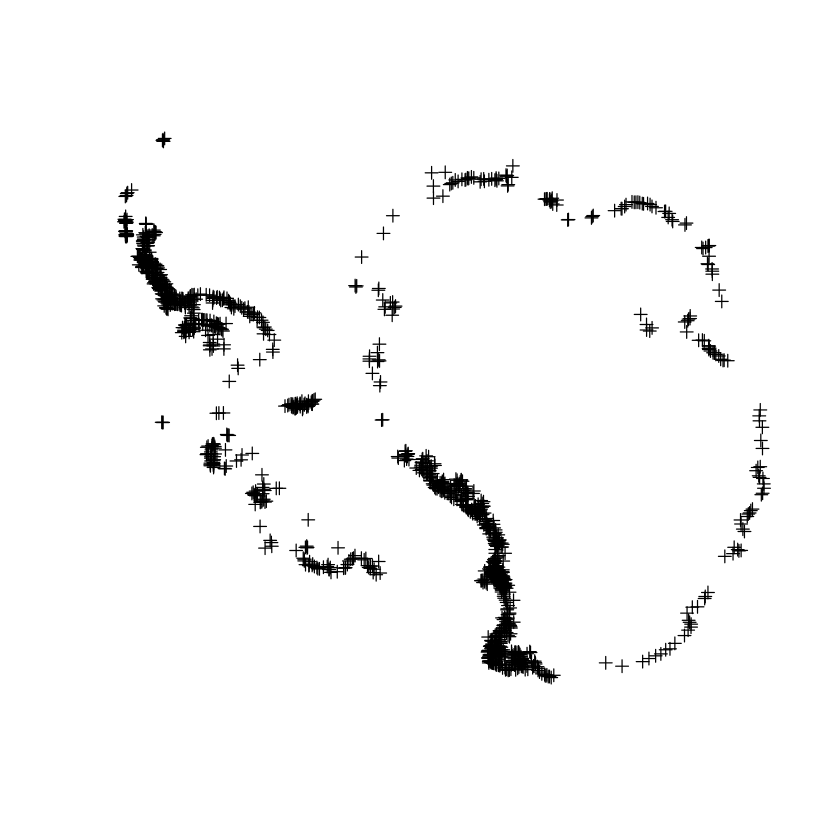

In [79]:
icebergs<-readShapeFile(pathToGit=pathToLocalGit,folderName="glaciers",shapeName="glaciers")
#folderName is the folder name in the workspace, and shapeName is the name of the .shp file
plot(icebergs)

We could (but we don't because this is a point shapefile, not a polygon shapefile) use the spatial object "icebergs" ploted above to attribute wesedf with some information in it. We can see the contents of "icebergs" with a head:

In [80]:
head(icebergs)

,objectid,fid_,place_name,place_na_1,gaz_id,country_na,latitude,longitude,altitude,feature_ty,⋯,max_digita,location_m,metadata_e,survey_sta,satellite_,online_dis,geometry,reason,relic_flag,country_id
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,59283,NA,Aagaard Glacier,Aagaard Glacier,121528,United States of America,-66.7667,-64.5167,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (-64.516667 -66.766667),NA,No,840
2,59285,NA,Aaron Glacier,Aaron Glacier,121530,United States of America,-85.1333,-90.6667,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (-90.666667 -85.133333),NA,No,840
3,59308,NA,Academy Glacier,Academy Glacier,121553,United States of America,-84.2500,-61.0000,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (-61 -84.25),NA,No,840
4,59329,NA,Adams Glacier,Adams Glacier,121575,United States of America,-66.8333,109.6667,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (109.666667 -66.833333),NA,No,840
5,59330,NA,Adams Glacier,Adams Glacier,121576,United States of America,-78.1167,163.6333,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (163.633333 -78.116667),NA,No,840
6,59364,NA,Aeronaut Glacier,Aeronaut Glacier,121611,United States of America,-73.2667,163.6000,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (163.6 -73.266667),NA,No,840


So, we could attribute the wesedf table with the parameter "place_name", like so:

In [81]:
## DO NOT RUN
## wesedf2<-attributeWithShape(shpobj=icebergs,attribName="place_name",data=wesedf,datKey="gridCellId",
##                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)

If we executed the above example, the resulting table wesedf2 will have a new field called "place_name."

__Regarding #2__ we use the function "bootSampleWESEdata". This function by default generates 100 bootstrap samples (but change with the parameter "nsamples") and returns a list object. Each element of the list is one of the samples. Each sample is a table like wesedf, but it contains an equal number of grids with seals and no seals.  
  
The wesedf table has a column called "hasMaps" to indicate cells with maps, even if these wereeventually estimated to have 0 seals. The function "bootSampleWESEdata" can treat these as if they had no seals, or as if they did. You may indicate the behavior with the parameter "hasMapsBehavior". Set the parameter to 0 (this is the default behavior) to treat these cells as if there are no seals there, or 1 otherwise.

Additionally, we my want to stratify the sample by bins of any one or two (but no more) of the variables in wesedf. To do so, we use the parameter "strtifyByClusters". This parameter is a number between 2 and 5. The function will find clusters in the covariate space in the data, then assign each record to one of these clusters, and it will then stratify the random sample such that it includes an even number of values in each of the clusters.  

Lastly, the function can also return an ensemble of data converted to presence-absence. Again, if a grid with maps is considered to have seals (i.e., hasMapsBehavior=1), then it will be assigned presence = 1.

Here's an example on how to create an ensemble of abundance (no clustering, just normal random sampling):

In [82]:
bootsamp<-bootSampleWESEdata(data=wesedf,nsamples=100,hasMapsBehavior=0,stratifyByClusters=0,countVar="mdlCol",setBinomial=FALSE)
head(bootsamp[[12]])
tail(bootsamp[[43]])
nrow(bootsamp[[7]])

,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,adpecol,empedist,empecol,cont300dist,cont800dist,coords.x1,coords.x2,abundance,mdlIsl,hasMaps
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8168,122030,2.5123022,-318.58,0.6027454,-310.1347,15187.383,169512.1,6,-212080.2,2144389,⋯,Thule Island,94659.60,Atka,73022.03,329705.0,-221000,2156000,15,18,1
8169,122031,1.2012005,-266.96,1.6832575,-268.1202,12905.335,166852.4,6,-212080.2,2144389,⋯,Thule Island,98906.23,Atka,73022.03,329705.0,-216000,2156000,42,51,1
8256,122158,0.4402819,-238.41,0.3618537,-237.5242,11069.010,165334.1,6,-212080.2,2144389,⋯,Thule Island,92058.26,Atka,76785.59,327298.0,-221000,2151000,58,68,1
8257,122159,0.5317709,-235.92,0.4853334,-227.2131,8542.728,162606.1,6,-212080.2,2144389,⋯,Thule Island,96419.53,Atka,76785.59,327298.0,-216000,2151000,11,14,1
8344,122286,0.3624971,-243.93,0.3787392,-242.3279,7719.291,161202.9,6,-214905.9,2140233,⋯,Thule Island,89660.51,Atka,80667.40,324950.0,-221000,2146000,41,50,1
8433,122414,0.5814596,-261.49,0.4114927,-262.9747,4871.616,157122.2,6,-219560.1,2136410,⋯,Thule Island,87483.08,Atka,84645.60,322661.1,-221000,2141000,35,41,1


,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,adpecol,empedist,empecol,cont300dist,cont800dist,coords.x1,coords.x2,abundance,mdlIsl,hasMaps
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
212653,1252355,1.7046343,-252.7959,2.0824969,-215.1550,0.000,32168.31,6,1401607.6,-2044280.1,⋯,SE Fisher Bay,32099.05,Mertz break off,1148042.6,1105816.2,1399000,-2034000,0,0,0
200718,1221283,4.7873082,-1497.9500,4.6513991,-1469.1035,103705.409,120432.72,6,345493.6,-2019378.7,⋯,Cape Adare,159147.94,Cape Roget,1200285.4,1160007.1,279000,-2099000,0,0,0
150070,826097,0.2038354,-496.7000,0.2290817,-498.3176,115889.474,199117.07,6,2665883.1,-505063.6,⋯,Merritt Island,166494.68,Bowman Island,254818.1,173487.8,2784000,-499000,0,0,0
178275,1059609,1.4472678,-507.4000,1.6294609,-499.4572,40843.743,97555.40,6,-524261.6,-1300517.0,⋯,Cruzen Island,55664.23,Cape Colbeck,732267.7,586189.7,-501000,-1344000,0,0,0
190883,1122507,0.1471168,-461.4500,0.1252840,-462.8557,81964.727,122627.53,6,2232138.8,-1211498.1,⋯,Henry Islands,128250.38,Sabrina coast,707509.5,510389.4,2309000,-1239000,0,0,0
194212,1130779,0.3995059,-588.8300,0.3317709,-591.8447,4497.212,36469.19,6,2071348.3,-1565424.5,⋯,Chick Islands,278013.43,Sabrina coast,825981.4,761724.3,2069000,-1564000,0,0,0


[1] 3368

#### __Regarding #3__ we use the function "fitModelToBootstrap" to fit a simple or generalized regression model to the full ensemble. The function just requires a formula, the ensemble as generated above, and the error family link (by default the Gaussian, which is a normal error).  
  
The default behavior (i.e., Gaussian error) fits a normal linear model. Otherwise, use "poisson" if you think it is appropriate for the counts, or "binomial" if fitting logistic regressions (that is, if you set the setBinomial parameter to TRUE when generating the ensemble above). In the case of poisson or logistic regression, a generalized linear model is fit. We can add a negative binomial option later, to accommodate for overdispersion. But for now let's start working with this to get it going.  
  
Whether fitting a simple regression or a generalized liner model, the output is the same, with the exception that R-squared values cannot be obtained from a GLM. Instead, the function returns the residual deviance of the model for each sample bootstrap.  
  
The function returns a list with 3 objects: coefficients, goodness-of-fit data, and residuals. But because it performs the model fit on an ensemble of data, it returns a collection of results within each of the above objects.  
  
For example, the coefficients object is actually 4 data.frames. Each data.frame has as many columns as datasets in the ensemble (from the example above, 100 columns), and each row in the data.frame is a different coefficient from the model. The four data.frames are, respectively: the coefficient estimates, their standard errors, t-values and p-values.  
  
The residuals data is a single data.frame: each row is a datum in the ensemble, each column is the set of residuals for each model fit. Since every bootstrap sample has 3368 records, this data.frame would have 3368 rows and 100 columns.
  
The GOF data is also only one data.frame. But unlike the other results above, each column is a GOF paramter, and each row is a different ensemble result. So, it has 4 columns: the degees of freedom of the model, the AIC of the model, the -2*logLikelyhood of the model, and the R-squared or residual deviance. Therefore, for example, with the above bootstrap ensemble the function would return a data.frame of 4 columns, and 100 rows.  
  
Let's try it.

In [83]:
reslst<-fitModelToBootstrap(fml="abundance~slope+bathy+shoredist+glacierdist",datalist=bootsamp)
## Note: not indicating the family so it defaults to "gaussian" and fits a simple regression

Let's examine the results, starting with a summary of the coefficients. For this we use the function "summarizeResults". The function has two arguments: the fitobj is the object resulting from using the fitModelToBootstrap function above (in our example, fitobj is reslst), and the "what" parameter. This parameter has three possible values: "coefs", "gof", or "resids". The latter is the vector of average residuals. Let's look at the coefficients and the goodness-of-fit results.

In [88]:
coefres<-summarizeResults(fitobj=reslst,what="coefs")
print(coefres)

              Parameter   Coefficient      StError    t_value       Prob_t
(Intercept) (Intercept) 99.0241269494 7.615259e+00 13.0043043 1.268834e-36
slope             slope  4.5325618945 2.127640e+00  2.1241212 3.847913e-02
bathy             bathy  0.0058720343 6.288768e-03  0.9348919 3.554552e-01
shoredist     shoredist -0.0003499718 1.207800e-04 -2.8986078 4.142464e-03
glacierdist glacierdist -0.0002090387 5.497766e-05 -3.8019720 1.690808e-04
            Nboot
(Intercept)   100
slope         100
bathy         100
shoredist     100
glacierdist   100


In [95]:
gofres<-summarizeResults(fitobj=reslst,what="gof")
print(gofres)

       Parameter         Value Nboot
Df            Df  3.362770e+03   100
AIC          AIC  4.716873e+04   100
LogLik    LogLik -2.357837e+04   100
Rsq          Rsq  2.895463e-02   100


In [96]:
residuals<-summarizeResults(fitobj=reslst,what="resids")
head(residuals)

[1] -44.185249 -23.684071  -2.834443 -51.909050 -21.918657 -29.795506